# Journey to Springfield - Классификация персонажей Симпсонов
Kaggle Competition: https://www.kaggle.com/competitions/journey-to-springfield

Задача многоклассовой классификации изображений персонажей Симпсонов. </br>
Необходимо определить, какой из 42 персонажей изображен на картинке. </br>
Используется предобученная модель ResNet50 с дообучением на датасете Симпсонов.

## ИМПОРТ БИБЛИОТЕК И КОНФИГУРАЦИЯ

In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='albumentations')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.models as models
import torchvision.io as io
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from datasets import SimpsonsDataset
from sklearn.metrics import f1_score
from collections import Counter

# Конфигурация
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Параметры
DATA_MODES = ['train', 'val', 'test']
TRAIN_DIR = Path('C:/AI/Stepik/content/train')
TEST_DIR = Path('C:/AI/Stepik/content/testset')
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]
RESCALE_SIZE = [224, 224]

# Параметры обучения
BATCH_SIZE = 256  
NUM_WORKERS = 8  
PREFETCH_FACTOR = 4  

Using device: cuda


## ПОДГОТОВКА И ЗАГРУЗКА ДАННЫХ

In [2]:
def setup_data():
    """
    Подготовка данных: загрузка путей к файлам, кодирование меток,
    разделение на train/val выборки
    
    Returns:
        train_files: список путей к обучающим изображениям
        val_files: список путей к валидационным изображениям
        test_files: список путей к тестовым изображениям
        label_encoder: кодировщик меток классов
    """

    # Загрузка путей ко всем изображениям
    train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
    test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

    # Создание и обучение LabelEncoder на именах папок (классах)
    label_encoder = LabelEncoder()
    train_val_labels = [path.parent.name for path in train_val_files]
    label_encoder.fit(train_val_labels)

    # Стратифицированное разделение на train и val (75%/25%)
    train_files, val_files = train_test_split(
        train_val_files, test_size=0.25, stratify=train_val_labels
    )

    # Статистика по классам
    train_labels = [path.parent.name for path in train_files]
    val_labels = [path.parent.name for path in val_files]
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    
    print("Количество объектов по классам:")
    for class_name in sorted(train_counts.keys()):
        class_id = label_encoder.transform([class_name])[0]
        print(f"Класс {class_id} ({class_name}): train={train_counts[class_name]}, val={val_counts[class_name]}")
    
    return train_files, val_files, test_files, label_encoder

def create_data_loaders(train_files, val_files, label_encoder):
    """
    Создание оптимизированных DataLoader'ов с учетом дисбаланса классов
    
    Args:
        train_files: список путей к обучающим изображениям
        val_files: список путей к валидационным изображениям
        label_encoder: кодировщик меток классов
    
    Returns:
        Словарь с train и val DataLoader'ами
    """

    # Создание датасетов
    train_dataset = SimpsonsDataset(train_files, label_encoder, mode='train')
    val_dataset = SimpsonsDataset(val_files, label_encoder=label_encoder, mode='val')

    # Взвешенный семплинг для борьбы с дисбалансом классов
    train_labels = [path.parent.name for path in train_files]
    class_counts = Counter(train_labels)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[path.parent.name] for path in train_files]
    sample_weights = torch.DoubleTensor(sample_weights)
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # с повторениями, чтобы классы выравнивались
    )
    
    # Оптимизированные DataLoader для обучающей выборки
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=True,  # Ускоряет передачу данных на GPU
        prefetch_factor=PREFETCH_FACTOR,
        persistent_workers=True,
        drop_last=True  # Игнорируем неполные батчи
    )

    # DataLoader для валидационной выборки
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        prefetch_factor=PREFETCH_FACTOR,
        persistent_workers=True
    )
    
    return {'train': train_loader, 'val': val_loader}

## СОЗДАНИЕ И НАСТРОЙКА МОДЕЛИ

In [3]:
def create_resnet50_model(n_classes):
    """
    Создание модели на основе предобученной ResNet50 с дообучением
    
    Args:
        n_classes: количество классов для классификации
    
    Returns:
        Модель ResNet50 с модифицированной головой
    """

    # Загрузка предобученной ResNet50
    model = models.resnet50(pretrained=True)
    
    # Замораживаем слои
    for param in model.parameters():
        param.requires_grad = False
    
    # Размораживаем последние слои для дообучения
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True
    
    # Заменяем финальный слой
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, n_classes)
    )
    
    print("Using PRETRAINED ResNet50")
    return model.to(DEVICE)

In [4]:
class SimpleCNN(nn.Module):
    """
    Кастомная сверточная нейронная сеть с BatchNorm и Dropout
    
    Args:
        n_classes: количество выходных классов
    """
    
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(12544, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        logits = self.out(x)
        return logits

def create_model(n_classes, model_version="resnet50"):
    """
    Фабрика моделей
    
    Args:
        n_classes: количество классов
        model_version: "resnet50" или "simple_cnn"
    
    Returns:
        Инициализированная модель на нужном устройстве
    """
    if model_version == "resnet50":
        model = create_resnet50_model(n_classes)
        print("Using pretrained ResNet50")
    else:
        model = SimpleCNN(n_classes)
        print("Using custom SimpleCNN")
    
    return model.to(DEVICE)

## ОБУЧЕНИЕ МОДЕЛИ

In [5]:
def train_epoch(model, train_loader, optimizer, criterion, scheduler=None):
    """
    Обучение модели на одной эпохе
    
    Args:
        model: модель для обучения
        train_loader: DataLoader обучающей выборки
        optimizer: оптимизатор
        criterion: функция потерь
        scheduler: планировщик скорости обучения
    
    Returns:
        Средние loss и accuracy на эпохе
    """
    
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Используем tqdm для прогресс-бара
    pbar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (images, targets) in enumerate(pbar):
        # Асинхронная передача на GPU
        images = images.to(DEVICE, non_blocking=True) #ОСТАВИЛ ИЗМЕНЕНИЕ
        targets = targets.to(DEVICE, non_blocking=True) #ОСТАВИЛ ИЗМЕНЕНИЕ
        
        optimizer.zero_grad() 
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Обновление learning rate по расписанию
        if scheduler:
            scheduler.step()
        
        # Расчет метрик
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        # Обновление прогресс-бара
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
        })
        
    # Расчет средних метрик на эпохе
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    """
    Валидация модели на одной эпохе
    
    Args:
        model: модель для валидации
        val_loader: DataLoader валидационной выборки
        criterion: функция потерь
    
    Returns:
        Средние loss, accuracy, F1-score на эпохе
    """
    
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Для расчета F1-score
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for images, targets in pbar:
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)
            

            outputs = model(images)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(targets).sum().item()
            total_samples += targets.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            
            
            pbar.set_postfix({
                'Loss': f'{running_loss/len(pbar):.4f}',
                'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
            })

    
    
    # Расчет метрик
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    # F1 для каждого класса
    f1_per_class = f1_score(all_targets, all_predictions, average=None, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='micro')
    
    return epoch_loss, epoch_acc, f1, f1_per_class

def train_model(model, loaders, num_epochs=20):
    """
    Полный цикл обучения модели
    
    Args:
        model: модель для обучения
        loaders: словарь с train и val DataLoader'ами
        num_epochs: количество эпох обучения
    
    Returns:
        Словарь с историей обучения
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)

    # OneCycleLR для адаптивного изменения learning rate
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-2, 
        epochs=num_epochs, 
        steps_per_epoch=len(loaders['train'])
    )
    
    # Массивы для хранения метрик
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    val_f1s = [] 
    
    print("Starting training...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Обучение на одной эпохе
        train_loss, train_acc = train_epoch(
            model, loaders['train'], optimizer, criterion, scheduler
        )
        
        # Валидация
        val_loss, val_acc, val_f1, val_f1_per_class = validate_epoch(model, loaders['val'], criterion)
        
        # Сохранение метрик
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        # Вывод результатов эпохи
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}')

    # Визуализация F1-score по классам
    plot_f1_scores(val_f1_per_class)
    
    # Вывод финальных результатов
    for i, v in enumerate(val_f1_per_class):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод в табличном виде
    print("\n" + "="*50)
    print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПО КЛАССАМ:")
    print("="*50)
    for class_id, f1 in enumerate(val_f1_per_class):
        print(f"Класс {class_id}: F1 = {f1:.4f}")
    
    return {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'val_f1': val_f1s
    }



## ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

In [6]:
def plot_f1_scores(f1_per_class):
    """
    Визуализация F1-score для каждого класса
    """
    plt.figure(figsize=(15, 6))
    classes = range(len(f1_per_class))
    plt.bar(classes, f1_per_class)
    plt.xlabel('Классы')
    plt.ylabel('F1-score')
    plt.title('F1-score по классам после обучения')
    plt.xticks(classes)
    
    # Добавление значений на столбцы
    for i, v in enumerate(f1_per_class):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_training_history(history):
    """
    Визуализация истории обучения
    
    Args:
        history: словарь с метриками обучения
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # График Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()



In [8]:
def check_gpu_utilization():
    """
    Проверка использования памяти GPU
    """
    if torch.cuda.is_available():
        print(f"Выделено памяти GPU: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
        print(f"Зарезервировано памяти GPU: {torch.cuda.memory_reserved()/1024**3:.2f} GB")


In [9]:
def imshow(inp, title=None, plt_ax=plt):
    """
    Вспомогательная функция для отображения изображений
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(NORMALIZE_MEAN)
    std = np.array(NORMALIZE_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


@torch.no_grad()
def visualize_predictions(n_rows, n_cols, dataset, model, label_encoder):
    """
    Визуализация предсказаний модели на случайных изображениях
    
    Args:
        n_rows: количество строк в grid
        n_cols: количество колонок в grid
        dataset: датасет для визуализации
        model: обученная модель
        label_encoder: кодировщик меток
    """
    import matplotlib.patches as patches
    from matplotlib.font_manager import FontProperties
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, 
        figsize=(n_cols * 4, n_rows * 4),
        sharey=True, sharex=True
    )
    
    for fig_x in axs.flatten():
        # Случайное изображение из датасета
        random_idx = int(np.random.uniform(0, len(dataset)))
        im_val, label = dataset[random_idx]
        
        # Получение истинной метки
        true_label = " ".join(
            map(lambda x: x.capitalize(),
                label_encoder.inverse_transform([label])[0].split('_'))
        )
        
        # Отображение изображения
        imshow(im_val.data.cpu(), title=true_label, plt_ax=fig_x)
        
        # Получение предсказания модели
        with torch.no_grad():
            prob_pred = nn.functional.softmax(
                model(im_val.unsqueeze(0).to(DEVICE)), dim=-1
            ).cpu().numpy()
        
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)
        
        # Преобразование предсказанной метки
        predicted_label = " ".join(
            map(lambda x: x.capitalize(),
                label_encoder.inverse_transform([y_pred])[0].split('_'))
        )
        
        predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)
        
        # Добавление подписи с предсказанием
        fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25, color='white'))
        fig_x.text(2, 195, predicted_text, 
                   horizontalalignment='left', 
                   verticalalignment='top',
                   fontsize=8, color='black', fontweight='bold')
        fig_x.set_axis_off()
    
    plt.tight_layout()
    plt.show()


## ПРЕДСКАЗАНИЕ НА ТЕСТОВЫХ ДАННЫХ И SUBMIT

In [10]:
def predict(model, loader):
    """
    Предсказание меток для всех объектов в DataLoader
    
    Args:
        model: обученная модель
        loader: DataLoader тестовых данных
    
    Returns:
        Tensor с предсказанными метками
    """
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    
    print("Прогнозирование на тестовых данных...")
    for inputs in tqdm(loader):
        inputs = inputs.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(inputs)
            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    
    return all_predictions.cpu()


def create_submission(model, test_files, label_encoder, output_path='predictions/submission.csv', predictions_dir="predictions"):
    """
    Создание файла для отправки на Kaggle
    
    Args:
        model: обученная модель
        test_files: список путей к тестовым изображениям
        label_encoder: кодировщик меток
        output_path: путь для сохранения файла
    """
    import os
    from datetime import datetime
    
    # Создание папки predictions, если ее нет
    os.makedirs(predictions_dir, exist_ok=True)
    
    
    # Создание тестового датасета и DataLoader
    test_dataset = SimpsonsDataset(test_files, label_encoder=label_encoder, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    
    # Получение предсказаний
    predicted_numeric_labels = predict(model, test_loader)
    predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)
    
    # Создание DataFrame с результатами
    submission_df = pd.DataFrame({
        'Id': [path.name for path in test_files],
        'Expected': predicted_text_labels
    })
    
    # Сохранение в CSV
    submission_df.to_csv(output_path, index=False)
    print(f"\nФайл для отправки сохранен: {output_path}")
    print(f"Количество предсказаний: {len(submission_df)}")
    print("\nПервые 10 строк:")
    print(submission_df.head(10))
    
    return submission_df

## ОСНОВНАЯ ФУНКЦИЯ ДЛЯ ЗАПУСКА

In [11]:
def main():
    """
    Основная функция для запуска всего пайплайна
    """
    print("="*60)
    print("ПРОЕКТ: КЛАССИФИКАЦИЯ ПЕРСОНАЖЕЙ СИМПСОНОВ")
    print("="*60)
    
    # 1. Подготовка данных
    print("\n1. Подготовка данных...")
    train_files, val_files, test_files, label_encoder = setup_data()
    
    # 2. Создание DataLoader'ов
    print("\n2. Создание DataLoader'ов...")
    loaders = create_data_loaders(train_files, val_files, label_encoder)
    
    # 3. Создание модели
    print("\n3. Создание модели...")
    n_classes = len(np.unique([path.parent.name for path in train_files + val_files]))
    model = create_model(n_classes, model_version="resnet50")
    
    # Информация о модели
    print(f"\nИнформация о модели:")
    print(f"- Количество классов: {n_classes}")
    print(f"- Параметров модели: {sum(p.numel() for p in model.parameters()):,}")
    print(f"- Обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # 4. Проверка GPU
    print("\n4. Проверка ресурсов GPU...")
    check_gpu_utilization()
    
    # 5. Обучение модели
    print("\n5. Обучение модели...")
    history = train_model(model, loaders, num_epochs=1)
    
    # 6. Визуализация результатов обучения
    print("\n6. Визуализация истории обучения...")
    plot_training_history(history)
    
    # 7. Визуализация предсказаний
    print("\n7. Визуализация предсказаний на валидационных данных...")
    val_dataset = SimpsonsDataset(val_files, label_encoder=label_encoder, mode='val')
    visualize_predictions(2, 4, val_dataset, model, label_encoder)
    
    # 8. Создание submission файла
    print("\n8. Создание файла для отправки на Kaggle...")
    submission = create_submission(model, test_files, label_encoder)
    
    # 9. Финальная проверка GPU
    print("\n9. Финальная проверка использования GPU...")
    check_gpu_utilization()
    
    return model, history, label_encoder, submission

# Запуск!


ПРОЕКТ: КЛАССИФИКАЦИЯ ПЕРСОНАЖЕЙ СИМПСОНОВ

1. Подготовка данных...
Количество объектов по классам:
Класс 0 (abraham_grampa_simpson): train=685, val=228
Класс 1 (agnes_skinner): train=32, val=10
Класс 2 (apu_nahasapeemapetilon): train=467, val=156
Класс 3 (barney_gumble): train=80, val=26
Класс 4 (bart_simpson): train=1006, val=336
Класс 5 (carl_carlson): train=74, val=24
Класс 6 (charles_montgomery_burns): train=895, val=298
Класс 7 (chief_wiggum): train=739, val=247
Класс 8 (cletus_spuckler): train=35, val=12
Класс 9 (comic_book_guy): train=352, val=117
Класс 10 (disco_stu): train=6, val=2
Класс 11 (edna_krabappel): train=343, val=114
Класс 12 (fat_tony): train=20, val=7
Класс 13 (gil): train=20, val=7
Класс 14 (groundskeeper_willie): train=91, val=30
Класс 15 (homer_simpson): train=1684, val=562
Класс 16 (kent_brockman): train=373, val=125
Класс 17 (krusty_the_clown): train=904, val=302
Класс 18 (lenny_leonard): train=233, val=77
Класс 19 (lionel_hutz): train=2, val=1
Класс 20 (lisa

C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using PRETRAINED ResNet50
Using pretrained ResNet50

Информация о модели:
- Количество классов: 42
- Параметров модели: 24,579,690
- Обучаемых параметров: 16,036,394

4. Проверка ресурсов GPU...
Выделено памяти GPU: 0.09 GB
Зарезервировано памяти GPU: 0.12 GB

5. Обучение модели...
Starting training...

Epoch 1/1
--------------------------------------------------


Validation: 100%|█████████████████████████████████████████████| 21/21 [00:38<00:00,  1.82s/it, Loss=0.4628, Acc=89.05%]


Train Loss: 0.9049, Train Acc: 78.41%
Val Loss: 0.4628, Val Acc: 89.05%, Val F1: 0.8905


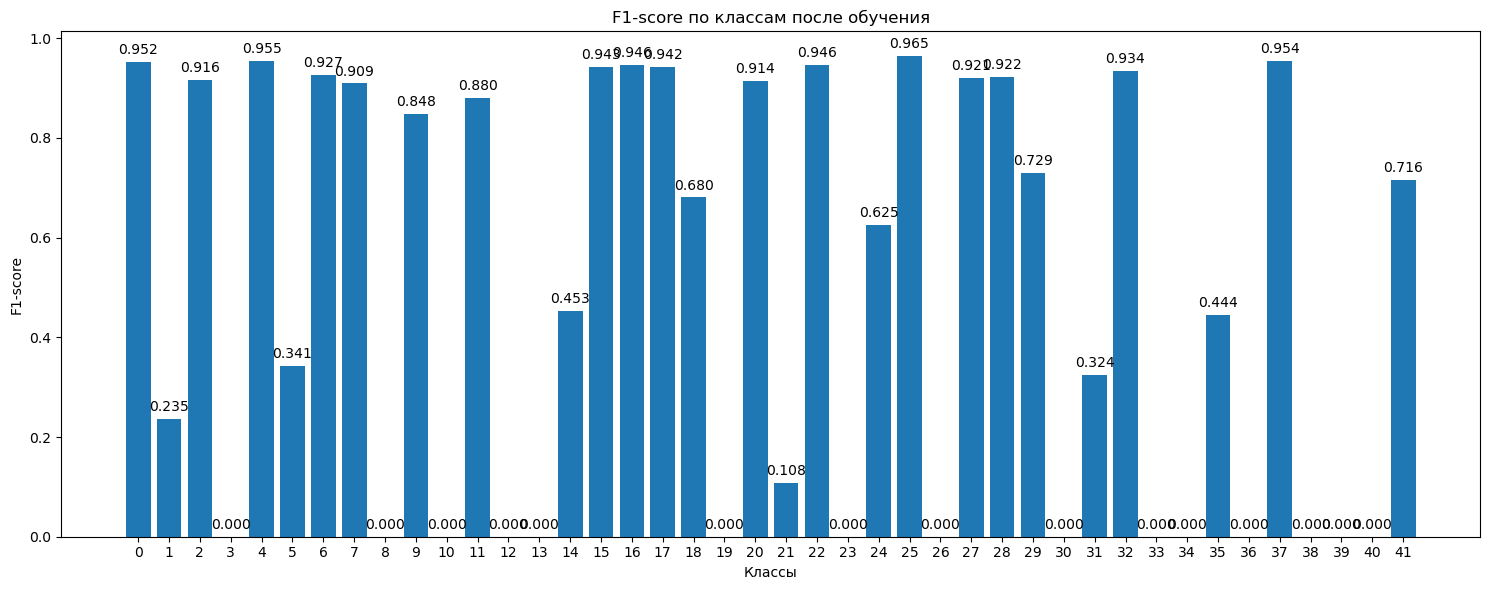

C:\Users\Shurik\AppData\Local\Temp\ipykernel_27520\1613586628.py:182: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


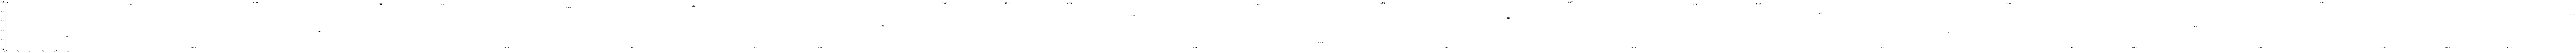


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПО КЛАССАМ:
Класс 0: F1 = 0.9522
Класс 1: F1 = 0.2353
Класс 2: F1 = 0.9157
Класс 3: F1 = 0.0000
Класс 4: F1 = 0.9548
Класс 5: F1 = 0.3415
Класс 6: F1 = 0.9270
Класс 7: F1 = 0.9091
Класс 8: F1 = 0.0000
Класс 9: F1 = 0.8485
Класс 10: F1 = 0.0000
Класс 11: F1 = 0.8803
Класс 12: F1 = 0.0000
Класс 13: F1 = 0.0000
Класс 14: F1 = 0.4528
Класс 15: F1 = 0.9428
Класс 16: F1 = 0.9462
Класс 17: F1 = 0.9422
Класс 18: F1 = 0.6804
Класс 19: F1 = 0.0000
Класс 20: F1 = 0.9144
Класс 21: F1 = 0.1081
Класс 22: F1 = 0.9463
Класс 23: F1 = 0.0000
Класс 24: F1 = 0.6250
Класс 25: F1 = 0.9651
Класс 26: F1 = 0.0000
Класс 27: F1 = 0.9210
Класс 28: F1 = 0.9224
Класс 29: F1 = 0.7290
Класс 30: F1 = 0.0000
Класс 31: F1 = 0.3243
Класс 32: F1 = 0.9342
Класс 33: F1 = 0.0000
Класс 34: F1 = 0.0000
Класс 35: F1 = 0.4444
Класс 36: F1 = 0.0000
Класс 37: F1 = 0.9539
Класс 38: F1 = 0.0000
Класс 39: F1 = 0.0000
Класс 40: F1 = 0.0000
Класс 41: F1 = 0.7160

6. Визуализация истории обучения...


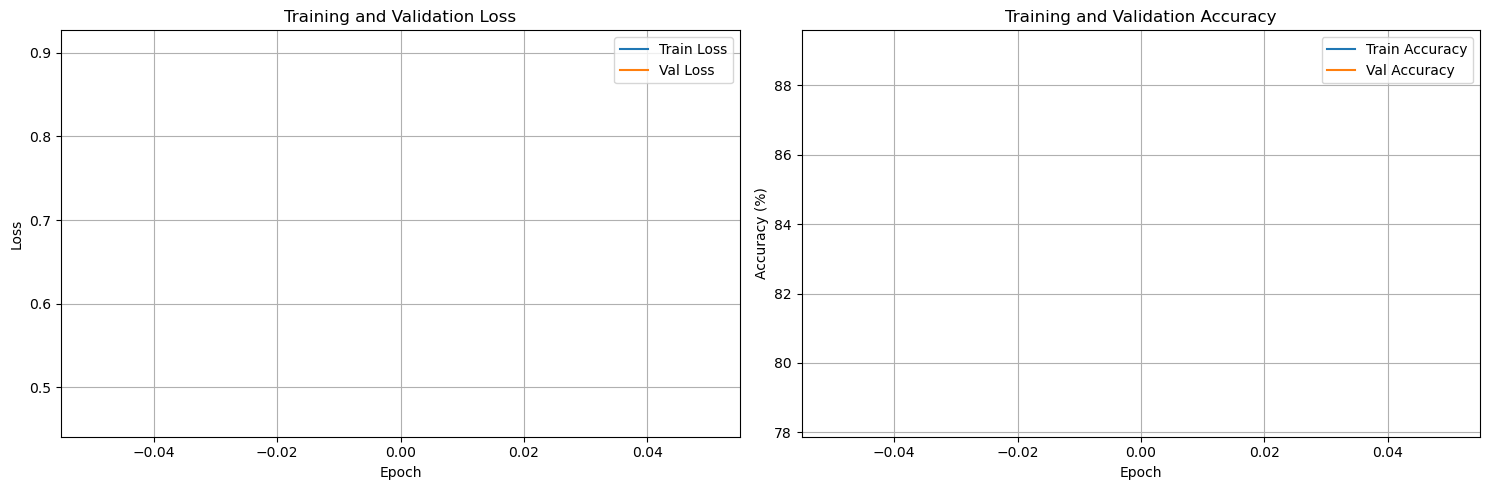


7. Визуализация предсказаний на валидационных данных...


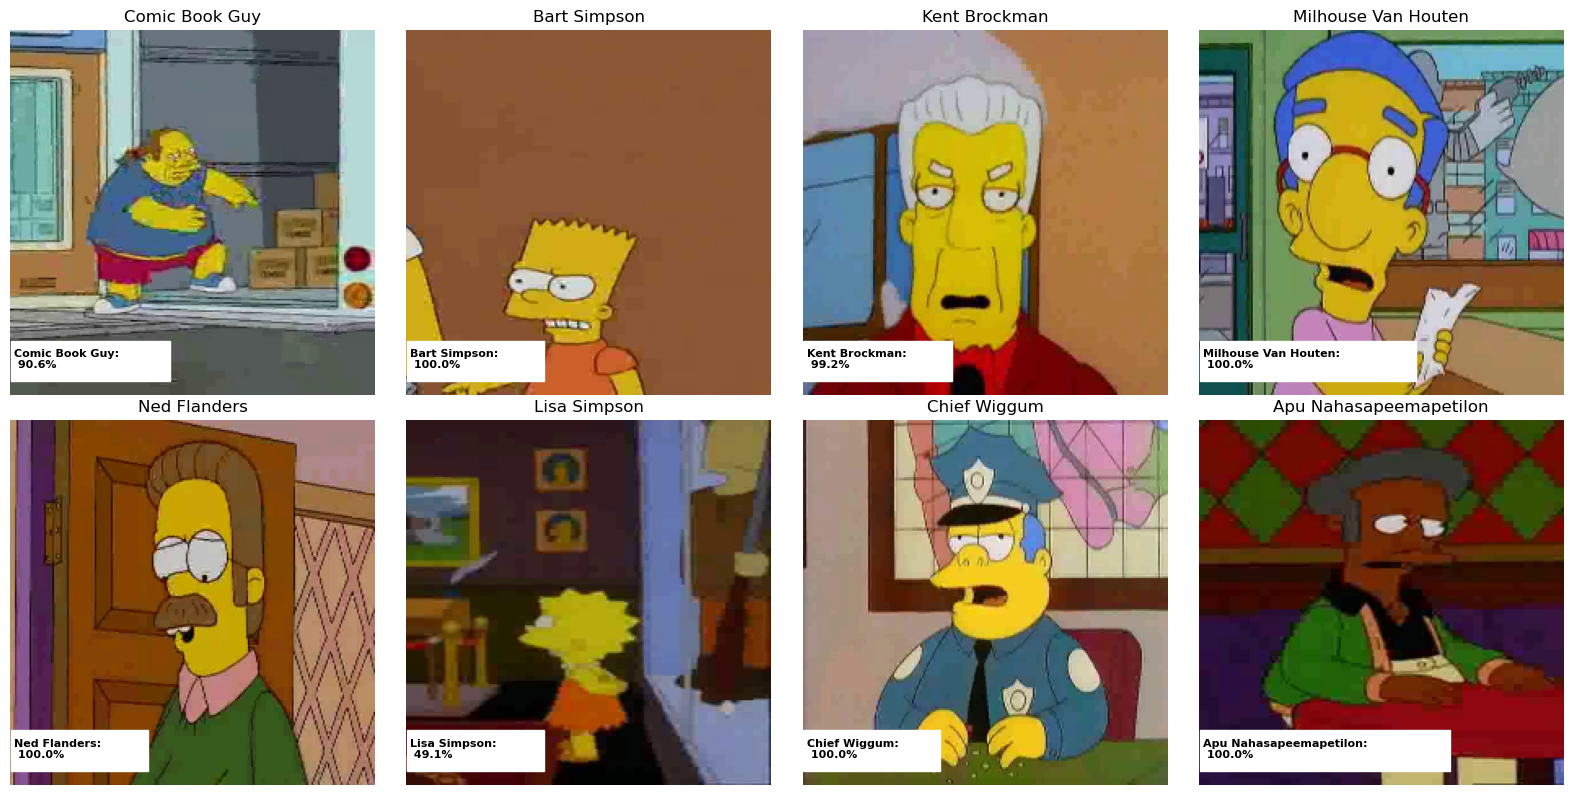


8. Создание файла для отправки на Kaggle...
Прогнозирование на тестовых данных...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.36it/s]



Файл для отправки сохранен: predictions/submission.csv
Количество предсказаний: 991

Первые 10 строк:
           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon
5  img102.jpg           kent_brockman
6  img103.jpg          edna_krabappel
7  img104.jpg            chief_wiggum
8  img105.jpg            lisa_simpson
9  img106.jpg           kent_brockman

9. Финальная проверка использования GPU...
Выделено памяти GPU: 0.17 GB
Зарезервировано памяти GPU: 4.09 GB


In [12]:
if __name__ == '__main__':
    # Очистка кэша GPU перед началом
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    model, history, label_encoder, submission = main()